## LSTM Language Modeling

In [ ]:
import torch
from torchtext import data
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
import numpy as np

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
from torchtext import datasets

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
training_set, testing_set = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 22.7MB/s]


In [ ]:
SEED = 1234
train_data, valid_data = training_set.split(random_state=random.seed(SEED))

In [ ]:
reviews = [vars(train_data.examples[i])['text'] for i in range(len(train_data.examples))]

In [ ]:
    list_of_words=[]

    def Ngrams(word_list, N):
        keys = set(zip(*[word_list[i:] for i in range(N)]))
        for a_key in keys:
            list_of_words.append(a_key)
        return list_of_words

    for ar in reviews:
        klist = Ngrams(ar, 4)

    lm = dict()
    for word in list_of_words:
        theseq = word[:-1]
        if theseq in lm:
            lm[theseq].append(word[-1])
        else:
            lm[theseq] = [word[-1]]

    import random
    def nextWord(thekey):
        next_possible = lm.get((thekey))
        return random.sample(next_possible,1)[0]

    def generateFurther(count, init):
        if not count:
            return init[0] + ' ' + init[1]
        next_word = nextWord(init)
        return init[0] + ' ' + generateFurther(count - 1, ((init[1], init[2],next_word)))


In [ ]:
generateFurther(20, ('my', 'favourite','movie'))

"my favourite movie ever , but they said it deserved better.<br /><br />The acting itself was n't too juicy to begin with"

In [ ]:
generateFurther(20, ('my', 'favourite','movie'))

"my favourite movie wen i was 5 and it still holds up well today . It 's true that sequels are usually"

In [ ]:
generateFurther(20, ('my', 'favourite','movie'))

'my favourite movie wen i was 5 and my family always watched this show a surreal and unique appearance . But also'

In [ ]:
generateFurther(20, ('my', 'favourite','movie'))

'my favourite movie wen i was 5 and my family always watched this game . It has tons of super - surreal'

In [ ]:
TEXT = data.Field(tokenize='spacy',eos_token='.')
LABEL = data.LabelField(dtype=torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)

In [ ]:
print(f'Number of training   examples: {len(train_data)}')
print(f'Number of testing    examples: {len(test_data)}')

Number of training   examples: 25000
Number of testing    examples: 25000


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
(train_data, test_data),
batch_size = 8,
device = device
)


TEXT.build_vocab(train_data, max_size=5000,vectors="glove.6B.100d",min_freq = 10)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399568/400000 [00:18<00:00, 21452.94it/s]

In [ ]:
#Building the model
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                           bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        
        
        emb = self.dropout(self.embedding(text))
        output, hidden = self.rnn(emb)
        output = self.dropout(output)
        decoded = self.fc(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1))

In [ ]:
#Model parameters
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 80
OUTPUT_DIM = INPUT_DIM
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model.embedding.weight.requires_grad = False
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.7, 0.99))

In [ ]:

pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([5003, 100])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.5781, -0.1730,  0.6635,  ..., -0.1843,  0.0376,  0.4232],
        [ 0.3135,  0.3104,  0.3291,  ..., -0.3923, -0.6504,  0.4120],
        [-0.3336,  0.1483,  0.1550,  ..., -0.3782,  0.6802, -0.1566]])

In [ ]:

from tqdm import tqdm

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    model.train()
    model = model.to(device)
    for batch in iterator:
        
        optimizer.zero_grad()
        predictions = model(batch.text[:-1])
        loss = criterion(predictions.view(-1,INPUT_DIM), batch.text[1:].view(-1))
        loss.backward(retain_graph=True)
        
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    
    model.eval()
    model = model.to(device)
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text[:-1])
            loss = criterion(predictions.view(-1,INPUT_DIM), batch.text[1:].view(-1))
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

In [ ]:
N_EPOCHS = 5
loss_history_1 = np.arange(0,N_EPOCHS,dtype=float)
for epoch in range(N_EPOCHS):

    train_loss = train(model, train_iterator, optimizer, criterion)
    loss_history_1[epoch] = train_loss
    valid_loss = evaluate(model, test_iterator, criterion)
    print('epoch: ',epoch, 'train_loss: ',train_loss,'validation_loss: ', valid_loss)

epoch:  0 train_loss:  2.7104149657440186 validation_loss:  5.0806547542572025
epoch:  1 train_loss:  2.4860390310668947 validation_loss:  4.926961108932495
epoch:  2 train_loss:  2.4453920764541626 validation_loss:  4.862266946640014
epoch:  3 train_loss:  2.4330751929473875 validation_loss:  4.8220201638031
epoch:  4 train_loss:  2.424115651435852 validation_loss:  4.7959206454467775


##### Plotting the graph for training loss and number of iterations 

Text(0, 0.5, 'Loss')

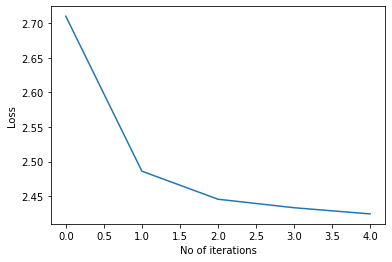

In [ ]:
plt.plot(np.arange(0,5),loss_history_1)
plt.xlabel('No of iterations')
plt.ylabel('Loss')

In [ ]:
import spacy
import numpy as np
nlp = spacy.load('en')
model = model.to(device)

def predict_vocab(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    model.eval()
    model.bsz = 1
    prediction = model(tensor)
    return prediction,tensor

In [ ]:
prediction,input_data = predict_vocab("my favorite movie")
x,preds = torch.max(prediction, 2)
output = [TEXT.vocab.itos[i] for i in preds]
total_data = torch.cat((input_data,preds),dim=0)

In [ ]:
for x in range(14):
    total_data = total_data.to('cpu')
    total_data_sampled = np.array(total_data[-6:])
    next_input = np.random.choice(total_data_sampled.reshape(total_data_sampled.shape[0]),1)
    next_input_text = [TEXT.vocab.itos[i] for i in next_input]
    next_input_text = ''.join(next_input_text)
    prediction,input_data = predict_vocab(next_input_text)
    x,preds = torch.max(prediction, 2)
    total_data = total_data.to('cuda')
    total_data = torch.cat((total_data,preds),dim=0)
sampled_output = [TEXT.vocab.itos[i] for i in total_data]
' '.join(sampled_output)

'my favorite movie <unk> <unk> . br /><br <unk> br /><br <unk> <unk> <unk> br /><br <unk> br /><br <unk> <unk> /><br <unk> br /><br <unk> /><br /><br <unk> <unk>'

In [ ]:
prediction,input_data = predict_vocab("My favorite movie")
x,preds = torch.max(prediction, 2)
output = [TEXT.vocab.itos[i] for i in preds]
total_data = torch.cat((input_data,preds),dim=0)

for x in range(14):
    total_data = total_data.to('cpu')
    total_data_sampled = np.array(total_data[-6:])
    next_input = np.random.choice(total_data_sampled.reshape(total_data_sampled.shape[0]),3)
    next_input_text = [TEXT.vocab.itos[i] for i in next_input]
    next_input_text = ''.join(next_input_text)
    prediction,input_data = predict_vocab(next_input_text)
    x,preds = torch.max(prediction, 2)
    total_data = total_data.to('cuda')
    total_data = torch.cat((total_data,preds),dim=0)
sampled_output = [TEXT.vocab.itos[i] for i in total_data]
' '.join(sampled_output)

'My favorite movie <unk> <unk> is <unk> br /><br <unk> /><br br /><br <unk> <unk> br /><br <unk> br /><br br /><br <unk> br /><br br /><br <unk> <unk> br /><br <unk> <unk> <unk> br /><br <unk> br /><br <unk> /><br br /><br br /><br <unk> <unk> <unk> <unk> br /><br <unk>'

In [ ]:
prediction,input_data = predict_vocab("my favorite movie")
x,preds = torch.max(prediction, 2)
output = [TEXT.vocab.itos[i] for i in preds]
total_data = torch.cat((input_data,preds),dim=0)

for x in range(14):
    total_data = total_data.to('cpu')
    total_data_sampled = np.array(total_data[-4:])
    next_input = np.random.choice(total_data_sampled.reshape(total_data_sampled.shape[0]),3)
    next_input_text = [TEXT.vocab.itos[i] for i in next_input]
    next_input_text = ''.join(next_input_text)
    prediction,input_data = predict_vocab(next_input_text)
    x,preds = torch.max(prediction, 2)
    total_data = total_data.to('cuda')
    total_data = torch.cat((total_data,preds),dim=0)
sampled_output = [TEXT.vocab.itos[i] for i in total_data]
' '.join(sampled_output)

'my favorite movie <unk> <unk> . br /><br <unk> <pad> br /><br <unk> /><br br /><br <unk> br /><br <unk> /><br br /><br <unk> <unk> <unk> br /><br <unk> /><br br /><br <unk> <unk> br /><br <unk> /><br br /><br <unk> br /><br <unk> <unk> <unk>'

In [ ]:
prediction,input_data = predict_vocab("My favorite movie")
x,preds = torch.max(prediction, 2)
output = [TEXT.vocab.itos[i] for i in preds]
total_data = torch.cat((input_data,preds),dim=0)

for x in range(14):
    total_data = total_data.to('cpu')
    total_data_sampled = np.array(total_data[-4:])
    next_input = np.random.choice(total_data_sampled.reshape(total_data_sampled.shape[0]),3)
    next_input_text = [TEXT.vocab.itos[i] for i in next_input]
    next_input_text = ''.join(next_input_text)
    prediction,input_data = predict_vocab(next_input_text)
    x,preds = torch.max(prediction, 2)
    total_data = total_data.to('cuda')
    total_data = torch.cat((total_data,preds),dim=0)
sampled_output = [TEXT.vocab.itos[i] for i in total_data]
' '.join(sampled_output)

'My favorite movie <unk> <unk> is is br /><br <unk> <unk> br /><br <unk> br /><br <unk> <unk> br /><br br /><br <unk> /><br br /><br <unk> br /><br <unk> br /><br <unk> br /><br br /><br <unk> /><br br /><br br /><br <unk> <unk> /><br br /><br <unk>'

In [ ]:
prediction,input_data = predict_vocab("My favorite movie")
x,preds = torch.max(prediction, 2)
output = [TEXT.vocab.itos[i] for i in preds]
total_data = torch.cat((input_data,preds),dim=0)

for x in range(14):
    total_data = total_data.to('cpu')
    total_data_sampled = np.array(total_data[-4:])
    next_input = np.random.choice(total_data_sampled.reshape(total_data_sampled.shape[0]),3)
    next_input_text = [TEXT.vocab.itos[i] for i in next_input]
    next_input_text = ''.join(next_input_text)
    prediction,input_data = predict_vocab(next_input_text)
    x,preds = torch.max(prediction, 2)
    total_data = total_data.to('cuda')
    total_data = torch.cat((total_data,preds),dim=0)
sampled_output = [TEXT.vocab.itos[i] for i in total_data]
' '.join(sampled_output)

'My favorite movie <unk> <unk> is is br /><br <unk> a br /><br <unk> <unk> br /><br br /><br <unk> <unk> <unk> br /><br <unk> <unk> br /><br <unk> br /><br <unk> <unk> br /><br <unk> <unk> <unk> br /><br <unk> br /><br <unk>'